In [2]:
import pandas as pd 
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

In [3]:
# SQL Server details
server = r"LAPTOP-VGS4C64G\SQLEXPRESS"
database = "E_Commerce"

# Use Windows Authentication
engine = create_engine(
    f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
)

In [4]:
# Load tables
orders = pd.read_sql('SELECT * FROM orders', engine)
order_items = pd.read_sql('SELECT * FROM order_items', engine)
order_item_refunds = pd.read_sql('SELECT * FROM order_item_refunds', engine)
products = pd.read_sql('SELECT * FROM products', engine)
website_pageviews = pd.read_sql('SELECT * FROM website_pageviews', engine)
w_sessions = pd.read_sql('SELECT * FROM w_sessions', engine)

# CHANNEL PORTFOLIO MANAGEMENT

### Revenue by UTM Source

In [5]:

order_sessions = pd.merge(orders,w_sessions,on='website_session_id',how='inner')
revenue_by_source=order_sessions.groupby(by='utm_source')['price_usd'].sum().reset_index()
revenue_by_source=revenue_by_source.sort_values('price_usd',ascending=False)
print(revenue_by_source)

   utm_source     price_usd
1     gsearch  1.276145e+06
3     unknown  3.714330e+05
0     bsearch  2.686725e+05
2  socialbook  2.225933e+04


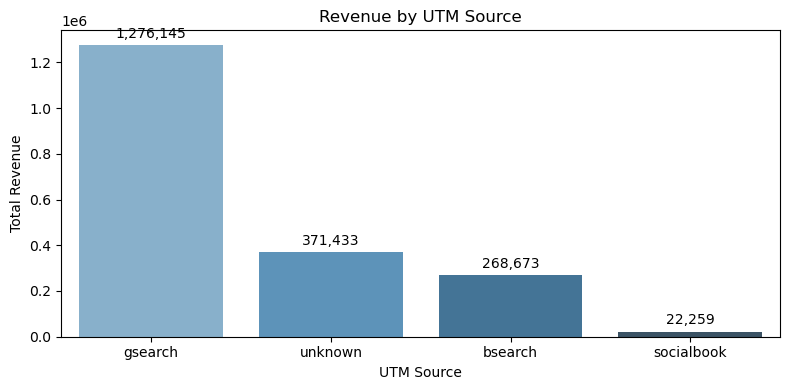

In [24]:
# 📊 Revenue by Source Bar Chart
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=revenue_by_source,
    x='utm_source',
    y='price_usd',
    hue='utm_source',
    palette='Blues_d',
    legend=False
)
plt.title('Revenue by UTM Source')
plt.xlabel('UTM Source')
plt.ylabel('Total Revenue')

# ✅ Add data labels with commas
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


### Conversion Rate by UTM Campaign

In [7]:
# Mark converted sessions by checking which session IDs exist in orders
converted_sessions = orders["website_session_id"].unique()
w_sessions["converted"] = w_sessions["website_session_id"].isin(converted_sessions).astype(int)

# Group by utm_campaign and compute CVR
campaign_analysis = (
    w_sessions.groupby("utm_campaign")
    .agg(
        total_sessions=("website_session_id", "count"),
        conversions=("converted", "sum")
    )
    .assign(CVR_percentage=lambda x: round((x["conversions"] / x["total_sessions"]) * 100, 2))
    .sort_values("CVR_percentage", ascending=False)
    .reset_index()
)

# Display results
print(campaign_analysis)

       utm_campaign  total_sessions  conversions  CVR_percentage
0             brand           41243         3212            7.79
1           unknown           83328         6118            7.34
2          nonbrand          337615        22640            6.71
3  desktop_targeted            5590          288            5.15
4             pilot            5095           55            1.08


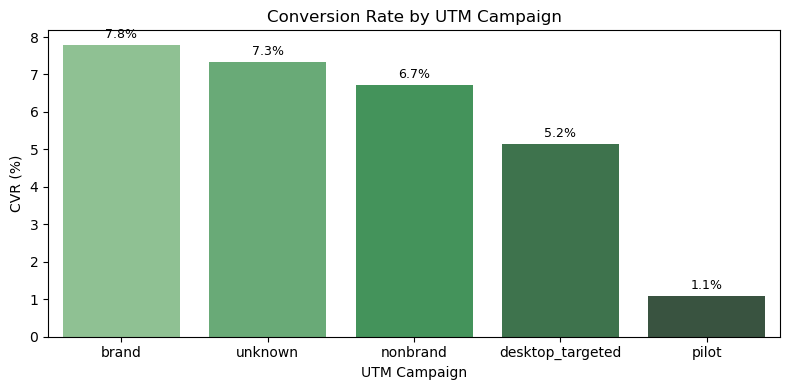

In [25]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=campaign_analysis,
    x='utm_campaign',
    y='CVR_percentage',
    hue='utm_campaign',
    palette='Greens_d',
    legend=False
)

plt.title('Conversion Rate by UTM Campaign')
plt.xlabel('UTM Campaign')
plt.ylabel('CVR (%)')

# ✅ Add data labels with one decimal and % sign
for container in ax.containers:
    labels = [f'{v.get_height():.1f}%' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()


### Brand vs Non-Brand Efficiency

In [9]:
# Tag sessions as brand vs. non-brand
w_sessions["campaign_type"] = w_sessions["utm_campaign"].apply(
    lambda x: "Brand" if "brand" in x.lower() else "Non-Brand"
)

# Mark converted sessions
converted_sessions = orders["website_session_id"].unique()
w_sessions["converted"] = w_sessions["website_session_id"].isin(converted_sessions).astype(int)

# Merge revenue from orders to w_sessions
revenue_map = orders.groupby("website_session_id")["price_usd"].sum().to_dict()
w_sessions["revenue"] = w_sessions["website_session_id"].map(revenue_map).fillna(0)

# Group by campaign type
efficiency_analysis = (
    w_sessions.groupby("campaign_type")
    .agg(
        total_sessions=("website_session_id", "count"),
        conversions=("converted", "sum"),
        total_revenue=("revenue", "sum")
    )
    .assign(CVR_percentage=lambda x: round((x["conversions"] / x["total_sessions"]) * 100, 2))
    .reset_index()
)

# Show result
print(efficiency_analysis)

  campaign_type  total_sessions  conversions  total_revenue  CVR_percentage
0         Brand          378858        25852   1.544817e+06            6.82
1     Non-Brand           94013         6461   3.936924e+05            6.87


C:\Users\Allu Rohith\AppData\Local\Temp\ipykernel_10120\1776466360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


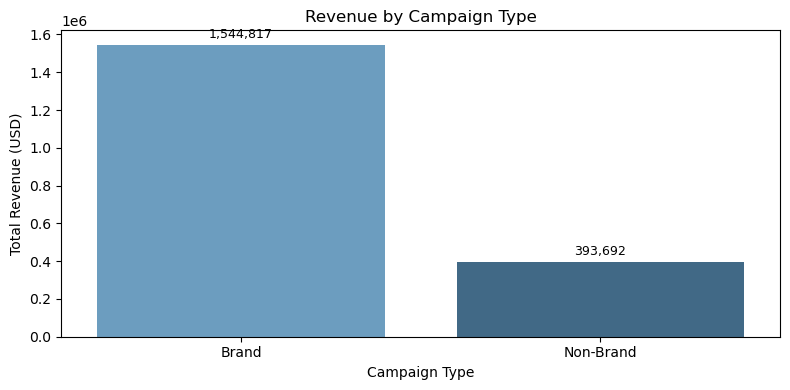

In [26]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=efficiency_analysis,
    x='campaign_type',
    y='total_revenue',
    palette='Blues_d',
    legend=False
)

plt.title('Revenue by Campaign Type')
plt.xlabel('Campaign Type')
plt.ylabel('Total Revenue (USD)')

# ✅ Add formatted data labels (e.g., 1,234)
for container in ax.containers:
    labels = [f'{bar.get_height():,.0f}' for bar in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=9)

plt.tight_layout()
plt.show()


### Pilot Campaign

In [ ]:
import pandas as pd

# Step 1: Filter 'Pilot' campaign sessions (case-insensitive)
pilot_sessions = w_sessions[w_sessions["utm_campaign"].str.lower() == "pilot"].copy()

# Check if there are any pilot sessions before proceeding
if not pilot_sessions.empty:
    # Step 2: Mark conversions (sessions that appear in orders)
    converted_sessions = orders["website_session_id"].unique()
    pilot_sessions["converted"] = pilot_sessions["website_session_id"].isin(converted_sessions).astype(int)

    # Step 3: Map revenue from orders to each session
    revenue_map = orders.groupby("website_session_id")["price_usd"].sum().to_dict()
    pilot_sessions["revenue"] = pilot_sessions["website_session_id"].map(revenue_map).fillna(0)

    # Step 4: Calculate total metrics
    total_sessions = len(pilot_sessions)
    conversions = pilot_sessions["converted"].sum()
    total_revenue = pilot_sessions["revenue"].sum()
    cvr = round((conversions / total_sessions) * 100, 2)

    # Step 5: Create summarized DataFrame
    pilot_roi = pd.DataFrame([{
        "utm_campaign": "Pilot",
        "total_sessions": total_sessions,
        "conversions": conversions,
        "total_revenue": total_revenue,
        "CVR_percentage": cvr
    }])

else:
    # If no Pilot sessions found
    pilot_roi = pd.DataFrame([{
        "utm_campaign": "Pilot",
        "total_sessions": 0,
        "conversions": 0,
        "total_revenue": 0,
        "CVR_percentage": 0
    }])

# Step 6: Display results
print(pilot_roi)

  utm_campaign  total_sessions  conversions  total_revenue  CVR_percentage
0        Pilot            5095           55    3743.230129            1.08


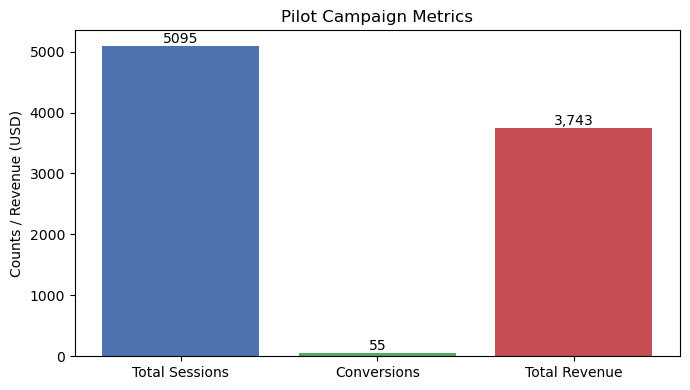

In [27]:
import matplotlib.pyplot as plt

# Values for plotting
metrics = ['Total Sessions', 'Conversions', 'Total Revenue']
values = [
    pilot_roi.loc[0, 'total_sessions'],
    pilot_roi.loc[0, 'conversions'],
    pilot_roi.loc[0, 'total_revenue']
]

# Format revenue with comma separator
labels = [f'{int(values[0])}', f'{int(values[1])}', f'{values[2]:,.0f}']

plt.figure(figsize=(7, 4))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52'])

# Add data labels
for bar, label in zip(bars, labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, label,
             ha='center', va='bottom', fontsize=10)

plt.title("Pilot Campaign Metrics")
plt.ylabel("Counts / Revenue (USD)")
plt.tight_layout()
plt.show()

### Revenue per Campaign

In [12]:
# Step 1: Map revenue from orders to session IDs
revenue_map = orders.groupby("website_session_id")["price_usd"].sum().to_dict()
w_sessions["revenue"] = w_sessions["website_session_id"].map(revenue_map).fillna(0)

# Step 2: Group by utm_campaign and compute metrics
revenue_per_campaign = (
    w_sessions.groupby("utm_campaign")
    .agg(
        total_sessions=("website_session_id", "count"),
        total_revenue=("revenue", "sum")
    )
    .assign(revenue_per_session=lambda x: round(x["total_revenue"] / x["total_sessions"], 2))
    .reset_index()
    .sort_values("revenue_per_session", ascending=False)
)

# Display result
print(revenue_per_campaign)

       utm_campaign  total_sessions  total_revenue  revenue_per_session
0             brand           41243   1.948397e+05                 4.72
4           unknown           83328   3.714330e+05                 4.46
2          nonbrand          337615   1.349978e+06                 4.00
1  desktop_targeted            5590   1.851610e+04                 3.31
3             pilot            5095   3.743230e+03                 0.73


# BUSINESS PATTERNS AND SEASONALITY

### Monthly Order Revenue Trends

In [13]:

# Step 1: Convert to datetime and extract month & year
orders["created_at"] = pd.to_datetime(orders["created_at"])
orders["month"] = orders["created_at"].dt.strftime("%b")          # e.g., Jan, Feb
orders["year"] = orders["created_at"].dt.year

# Optional: Keep months in correct calendar order
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
orders["month"] = pd.Categorical(orders["month"], categories=month_order, ordered=True)

# Step 2: Aggregate by month and year
monthly_analysis = (
    orders.groupby(["year", "month"])
    .agg(
        total_orders=("order_id", "count"),
        total_revenue=("price_usd", "sum")
    )
    .reset_index()
    .sort_values(["year", "month"])
)

# View summary
print(monthly_analysis)

    year month  total_orders  total_revenue
0   2012   Jan             0       0.000000
1   2012   Feb             0       0.000000
2   2012   Mar            60    2999.400101
3   2012   Apr            99    4949.010166
4   2012   May           108    5398.920181
5   2012   Jun           140    6998.600235
6   2012   Jul           169    8448.310284
7   2012   Aug           228   11397.720383
8   2012   Sep           287   14347.130482
9   2012   Oct           371   18546.290623
10  2012   Nov           618   30893.821037
11  2012   Dec           506   25294.940849
12  2013   Jan           390   19966.100655
13  2013   Feb           498   26515.020836
14  2013   Mar           385   19896.150646
15  2013   Apr           553   28584.470928
16  2013   May           571   29364.290958
17  2013   Jun           593   30544.070995
18  2013   Jul           604   31143.961014
19  2013   Aug           608   31373.921021
20  2013   Sep           629   32723.651066
21  2013   Oct           708   3

C:\Users\Allu Rohith\AppData\Local\Temp\ipykernel_10120\768152716.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders.groupby(["year", "month"])


### Chart for Total Orders

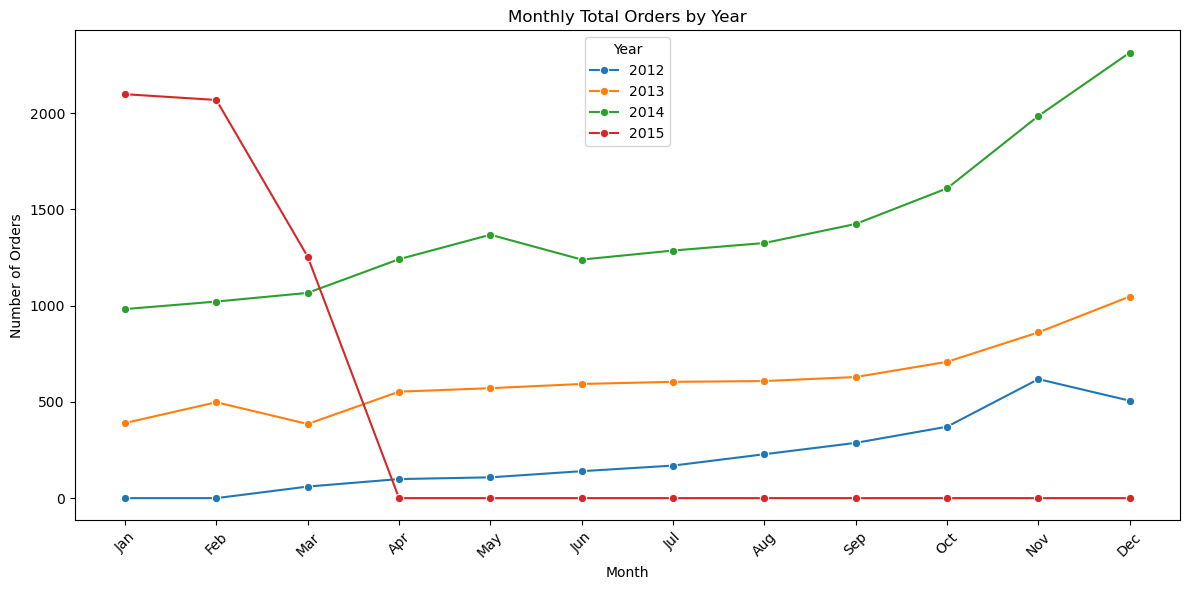

In [14]:


# Plot total orders over months, grouped by year
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_analysis,
    x='month',
    y='total_orders',
    hue='year',
    marker='o',
    palette='tab10'
)

plt.title("Monthly Total Orders by Year")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Chart for Revenue

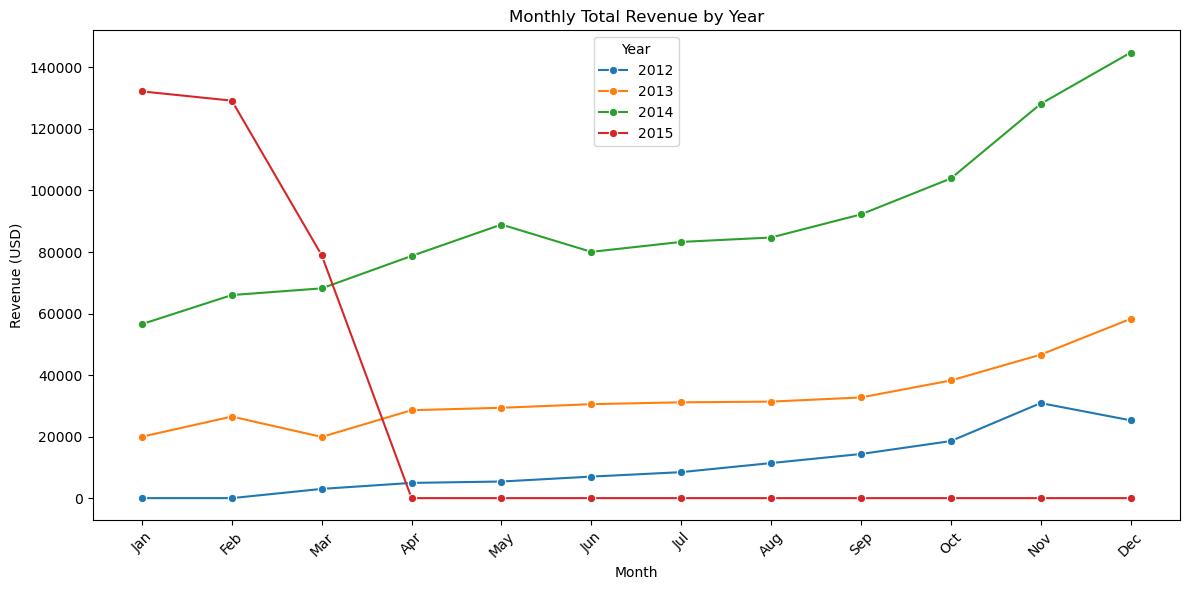

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_analysis,
    x='month',
    y='total_revenue',
    hue='year',
    marker='o',
    palette='tab10'
)

plt.title("Monthly Total Revenue by Year")
plt.xlabel("Month")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Traffic Time Pattern

In [16]:
import pandas as pd

# Step 1: Ensure 'created_at' is datetime
w_sessions["created_at"] = pd.to_datetime(w_sessions["created_at"])

# Step 2: Extract weekday and hour
w_sessions["weekday"] = w_sessions["created_at"].dt.day_name()  # 'Monday', 'Tuesday', etc.
w_sessions["hour"] = w_sessions["created_at"].dt.hour           # 0–23

# Step 3: Chronological weekday ordering
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
w_sessions["weekday"] = pd.Categorical(w_sessions["weekday"], categories=weekday_order, ordered=True)

# Step 4: Count sessions per day/hour
traffic_time_pattern = (
    w_sessions.groupby(["weekday", "hour"], observed=True)
    .agg(session_count=("website_session_id", "count"))
    .reset_index()
)

# Step 5: Pivot table for visualization
traffic_pivot = traffic_time_pattern.pivot(index="hour", columns="weekday", values="session_count").fillna(0)

# Step 6: Display results
print("\nSession counts by weekday and hour:\n")
print(traffic_time_pattern.head())

print("\nPivot table for heatmap (hour vs weekday):\n")
print(traffic_pivot.head())


Session counts by weekday and hour:

  weekday  hour  session_count
0  Monday     0           2133
1  Monday     1           1896
2  Monday     2           1565
3  Monday     3           1480
4  Monday     4           1282

Pivot table for heatmap (hour vs weekday):

weekday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                   
0          2133     1570       1758      1877    1933      1407    1077
1          1896     1437       1397      1387    1653      1178     927
2          1565     1056       1347      1484    1469       890     841
3          1480     1075       1242      1111    1198       818     778
4          1282     1252       1215      1176    1406       805     753


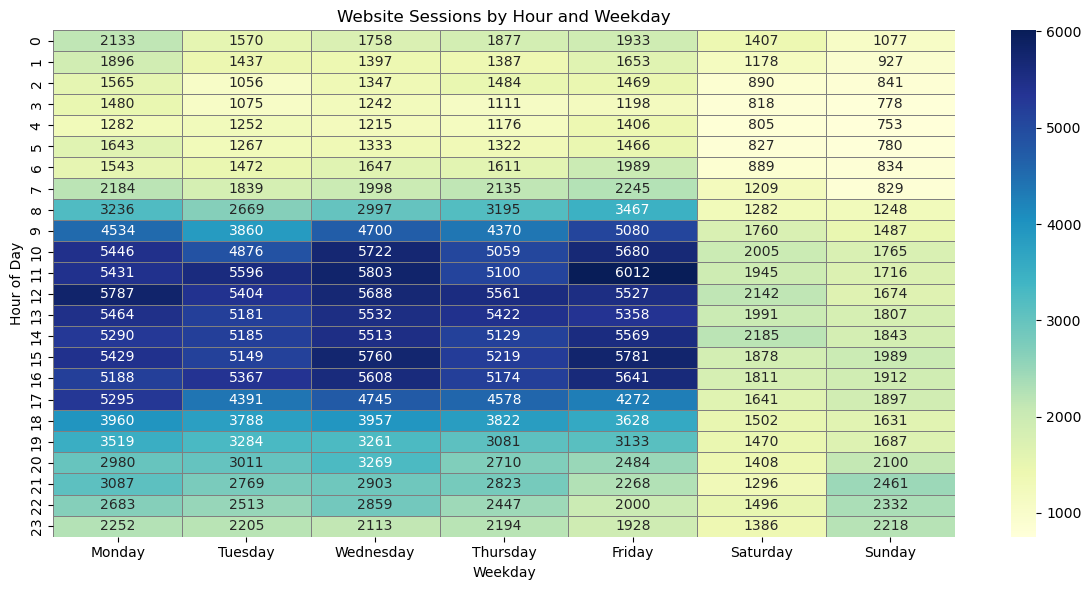

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure traffic_pivot is already created from previous step
plt.figure(figsize=(12, 6))
sns.heatmap(
    traffic_pivot,
    cmap="YlGnBu",         # Color palette
    linewidths=0.5,
    linecolor='gray',
    annot=True,            # Show session counts
    fmt=".0f"              # Format numbers as integers
)

plt.title("Website Sessions by Hour and Weekday")
plt.xlabel("Weekday")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

### Time-based Conversion Trends​

In [18]:
import pandas as pd

# Step 1: Convert timestamp to datetime
w_sessions["created_at"] = pd.to_datetime(w_sessions["created_at"])

# Step 2: Extract weekday and hour
w_sessions["weekday"] = w_sessions["created_at"].dt.day_name()
w_sessions["hour"] = w_sessions["created_at"].dt.hour

# Optional: Chronological weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
w_sessions["weekday"] = pd.Categorical(w_sessions["weekday"], categories=weekday_order, ordered=True)

# Step 3: Mark whether session converted
converted_sessions = orders["website_session_id"].unique()
w_sessions["converted"] = w_sessions["website_session_id"].isin(converted_sessions).astype(int)

# Step 4: Group and calculate session counts & conversions
conversion_trends = (
    w_sessions.groupby(["weekday", "hour"], observed=True)
    .agg(
        total_sessions=("website_session_id", "count"),
        conversions=("converted", "sum")
    )
    .assign(
        CVR_percentage=lambda x: round((x["conversions"] / x["total_sessions"]) * 100, 2)
    )
    .reset_index()
)

# Step 5: Optional pivot table for heatmap
conversion_pivot = conversion_trends.pivot(index="hour", columns="weekday", values="CVR_percentage").fillna(0)

# Preview result
print(conversion_trends.head())

  weekday  hour  total_sessions  conversions  CVR_percentage
0  Monday     0            2133          149            6.99
1  Monday     1            1896          140            7.38
2  Monday     2            1565          108            6.90
3  Monday     3            1480           86            5.81
4  Monday     4            1282           89            6.94


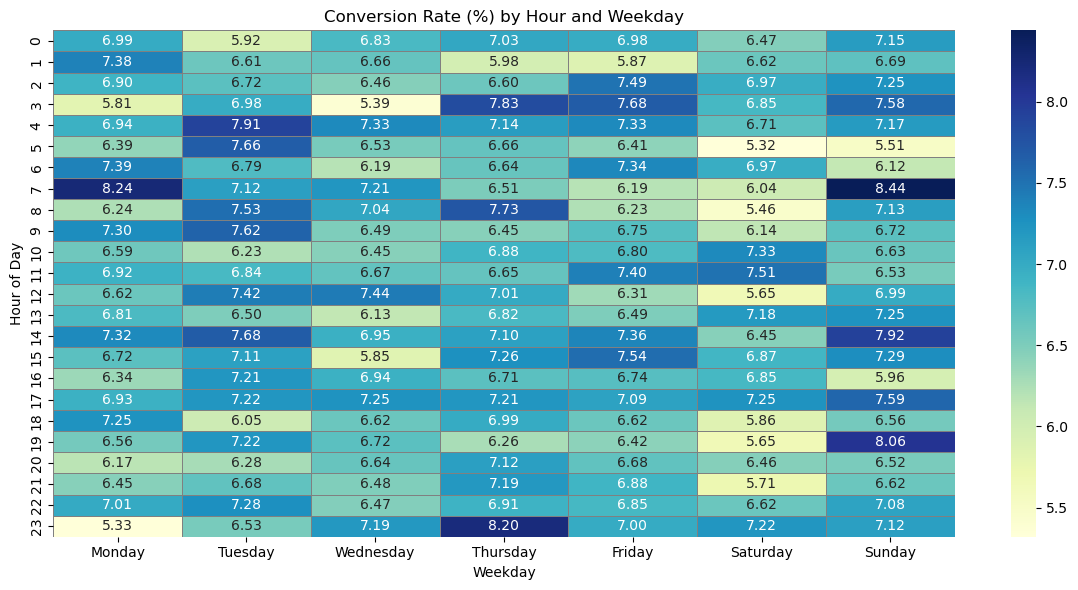

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'conversion_pivot' is created from previous step
plt.figure(figsize=(12, 6))
sns.heatmap(
    conversion_pivot,
    cmap="YlGnBu",         # Warm color palette for conversion intensity
    linewidths=0.5,
    linecolor='gray',
    annot=True,            # Show CVR percentages
    fmt=".2f"              # Format as percentage
)

plt.title("Conversion Rate (%) by Hour and Weekday")
plt.xlabel("Weekday")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

### MoM Revenue Growth

In [20]:
import pandas as pd

# Step 1: Convert to datetime and create 'order_month'
orders["created_at"] = pd.to_datetime(orders["created_at"])
orders["order_month"] = orders["created_at"].dt.to_period("M").astype(str)  # e.g., '2024-06'

# Step 2: Aggregate monthly revenue
monthly_analysis = (
    orders.groupby("order_month")
    .agg(total_revenue=("price_usd", "sum"))
    .reset_index()
)

# Step 3: Convert 'order_month' to datetime for growth calculations
monthly_analysis["order_month"] = pd.to_datetime(monthly_analysis["order_month"])

# Step 4: Extract year and month
monthly_analysis["year"] = monthly_analysis["order_month"].dt.year
monthly_analysis["month"] = monthly_analysis["order_month"].dt.month

# Step 5: Sort and calculate Month-over-Month (MoM) growth
monthly_analysis = monthly_analysis.sort_values(["year", "month"]).reset_index(drop=True)
monthly_analysis["MoM_growth_%"] = monthly_analysis["total_revenue"].pct_change().round(4) * 100

# Step 6: Year-over-Year (YoY) comparison using pivot
revenue_pivot = monthly_analysis.pivot_table(index="month", columns="year", values="total_revenue")

# Step 7: Calculate YoY growth between last two years
latest_year = revenue_pivot.columns[-1]
previous_year = revenue_pivot.columns[-2]
revenue_pivot["YoY_growth_%"] = (
    (revenue_pivot[latest_year] - revenue_pivot[previous_year]) / revenue_pivot[previous_year]
).round(4) * 100

# Step 8: Display results
print("\n📈 Month-over-Month Growth:\n")
print(monthly_analysis[["order_month", "total_revenue", "MoM_growth_%"]].tail())

print("\n📊 Year-over-Year Growth Comparison:\n")
print(revenue_pivot[[previous_year, latest_year, "YoY_growth_%"]])


📈 Month-over-Month Growth:

   order_month  total_revenue  MoM_growth_%
32  2014-11-01  128162.984535         23.35
33  2014-12-01  144823.024933         13.00
34  2015-01-01  132211.544456         -8.71
35  2015-02-01  129212.944269         -2.27
36  2015-03-01   78951.072683        -38.90

📊 Year-over-Year Growth Comparison:

year            2014           2015  YoY_growth_%
month                                            
1       56568.891865  132211.544456        133.72
2       66012.522263  129212.944269         95.74
3       68189.732395   78951.072683         15.78
4       78725.432781            NaN           NaN
5       88935.273144            NaN           NaN
6       80051.252811            NaN           NaN
7       83288.552929            NaN           NaN
8       84716.083008            NaN           NaN
9       92232.493275            NaN           NaN
10     103905.983696            NaN           NaN
11     128162.984535            NaN           NaN
12     144823.02493

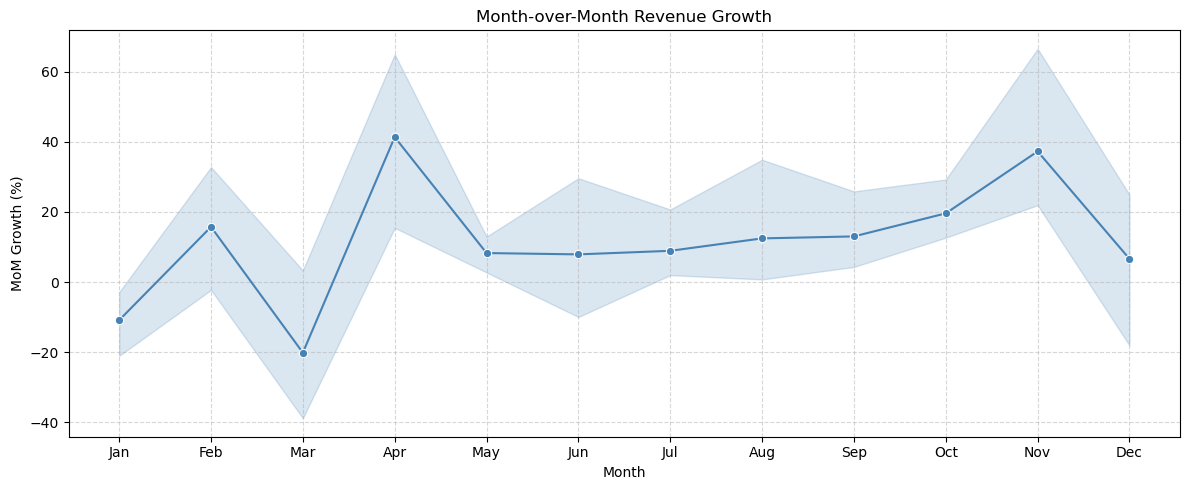

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert datetime to abbreviated month names
monthly_analysis["month_name"] = monthly_analysis["order_month"].dt.strftime("%b")

# Optional: Ensure months are ordered chronologically
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_analysis["month_name"] = pd.Categorical(monthly_analysis["month_name"], categories=month_order, ordered=True)

# Line Chart for MoM Growth
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=monthly_analysis,
    x='month_name',
    y='MoM_growth_%',
    marker='o',
    color='steelblue'
)

plt.title("Month-over-Month Revenue Growth")
plt.xlabel("Month")
plt.ylabel("MoM Growth (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()